In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
from functools import partial

from scipy.optimize import minimize_scalar
from statsmodels.tsa.api import  SimpleExpSmoothing

%matplotlib inline



In [2]:
# %pip install ipdb

In [3]:
import ipdb
# Basic parameters

In [4]:
def dbl_SEWMA(data, alpha):
    mod1 = SimpleExpSmoothing(data, initialization_method="heuristic").fit(smoothing_level=alpha, optimized=False)
    return {'sse':mod1.sse, 'mod':mod1}


In [5]:
def flat_with_noise(start_value=10., n_years=5, chgrat=0.20):
    # function to produce a level change
    output = np.zeros(n_years) + start_value
    chgsize = chgrat*start_value
    dmin = int(-1*chgsize)
    dmax = int(chgsize)
    output += np.array([randint(dmin, dmax) for x in range(n_years)])
    return(output)

In [6]:
def impulse(start_value=10., n_years=5, impyr=2, chgrat=.670, impsign=1):
    # function to produce an impulsive change 
    chgsize = chgrat*start_value
    out = np.array([start_value for x in range(n_years)]) 
    out[impyr:n_years] = impsign*chgsize +  out[impyr]
    return(out)

In [7]:
def cvx_change(start_value=10., n_years=5, chgsign=1, chgrat=.20):
    #function to produce convex change 
    # i.e. change where the time series of population falls below the line connecting any two 
    # points on the time series, i.e. alpha*exp(t) or alpha*exp(n_years - t)
    chgsize = chgrat*start_value
    
    alpha = np.exp(np.log(1+chgsign*chgrat)/n_years) - 1
    output = start_value * np.power(1. + alpha, np.linspace(1,n_years,n_years))
    
    return(output)

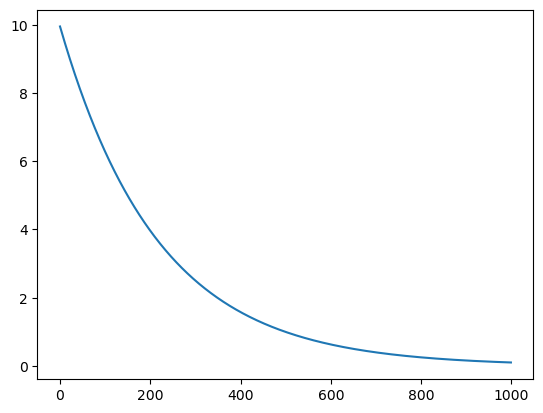

In [8]:
plt.plot(cvx_change(n_years=1000,chgrat=.99,chgsign=-1))

In [9]:
def ccv_change(start_value=10.,n_years=5,alpha=0.75,chgsign=1, chgrat=.20):
    #function to produce convex change 
    # i.e. change where the time series of population falls below the line connecting any two 
    # points on the time series, i.e. alpha*exp(t) or alpha*exp(n_years - t)
    adjust = 0.5*np.pi if chgsign < 0 else 0
    out = np.linspace(0,0.5*np.pi, n_years+1)
    out += adjust
    maxi = (1+chgrat*chgsign)*start_value
    mini = min(start_value, maxi)
    maxi = max(start_value, maxi)
    output = (maxi-mini)*np.sin(out) + mini
    return(output[1:])

In [10]:
sscRat = 100
tolerance = (-0.5, 0.25)
Alphas = np.linspace(.1,1,10)
pselect = [0.1 for x in Alphas]
growthPats = {'flat':flat_with_noise, 
              'impUp':impulse, 
              'impDn':partial(impulse, impsign=-1), 
              'cvxUp':cvx_change, 
              'cvxDn':partial(cvx_change, chgsign=-1),
              'ccvUp':ccv_change,
              'ccvDn':partial(ccv_change, chgsign=-1)
              }
NSchool = 11
len_history = 50

In [11]:
def simulate_history(start_value=50, total_years=50, period_length=5):
    history = [[start_value for x in range(period_length)]]
            # need to add functionality to smooth the transitions 
    
    for _, tp in enumerate(range(total_years//period_length)):
        locidx = randint(0,len(growthPats)-1) # there are 7 locidxs
        # locidx = 6 # 4 and 6 need work
        print(f"starting history {locidx}, a/k/a {repr(list(growthPats.values())[locidx])}")
        print(_)
        lochg = history[_][period_length-1] 
        print(lochg)
        # ipdb.set_trace()
        locfun = list(growthPats.values())[locidx](start_value=lochg, n_years=period_length) 
        local_h = np.squeeze(locfun)
        # local_h = local_h[1:len(local_h) ]
        print(local_h)
        history.append(local_h)
        print("____")

    out = np.floor(np.hstack(history)[period_length:])
    print(out)
    return out[period_length:]


In [12]:
def predict_from_history(schooldata,alpha_set=[0.1,0.5,0.7],years=5):
    school_SEWMA = lambda a: dbl_SEWMA(data=schooldata, alpha=a)
    fit_res = {}
    models = {}
    for j in alpha_set:
        ssmwa = school_SEWMA(j)
        fit_res[j] = ssmwa['sse']
        models[j] = ssmwa['mod']
        
    
    fit_check = pd.Series(fit_res)
    result = fit_check.index[fit_check.argmin()]
    pr = (models[result].forecast(1) + schooldata[-1])/NSchool
    return {"alpha_result":result, "prediction":models[result].forecast(years), "pred_ratio":pr,"history":models[result].fittedvalues}

In [13]:
sim1 = simulate_history(start_value=5000,period_length=12)

starting history 6, a/k/a functools.partial(<function ccv_change at 0x00000218BCF24900>, chgsign=-1)
0
5000
[4991.44486137 4965.92582629 4923.87953251 4866.02540378 4793.35334029
 4707.10678119 4608.76142901 4500.         4382.68343237 4258.8190451
 4130.52619222 4000.        ]
____
starting history 5, a/k/a <function ccv_change at 0x00000218BCF24900>
1
4000.0
[4104.42095378 4207.05523608 4306.14674589 4400.         4487.00914321
 4565.68542495 4634.68267223 4692.82032303 4739.10362601 4772.74066103
 4793.1558891  4800.        ]
____
starting history 0, a/k/a <function flat_with_noise at 0x00000218BCE8D260>
2
4800.0
[4509. 4760. 4159. 4202. 4794. 3873. 4623. 4666. 4234. 5409. 4276. 4643.]
____
starting history 2, a/k/a functools.partial(<function impulse at 0x00000218BCE8D760>, impsign=-1)
3
4643.0
[4643.   4643.   1532.19 1532.19 1532.19 1532.19 1532.19 1532.19 1532.19
 1532.19 1532.19 1532.19]
____
[4991. 4965. 4923. 4866. 4793. 4707. 4608. 4500. 4382. 4258. 4130. 4000.
 4104. 4207. 

In [14]:
predicres1 = predict_from_history(schooldata=sim1[0:13],years=4)
predicres2 = predict_from_history(schooldata=sim1[0:25],years=4)
predicres3 = predict_from_history(schooldata=sim1[0:35],years=4)

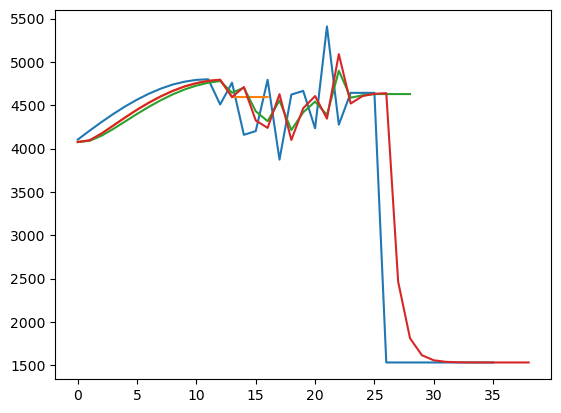

In [15]:
plt.plot(sim1)
plt.plot(np.hstack((predicres1['history'],  predicres1['prediction'])))
plt.plot(np.hstack((predicres2['history'],  predicres2['prediction'])))
plt.plot(np.hstack((predicres3['history'],  predicres3['prediction'])))

In [16]:
predicres1


{'alpha_result': 0.7,
 'prediction': array([4594.65649802, 4594.65649802, 4594.65649802, 4594.65649802]),
 'pred_ratio': array([827.60513618]),
 'history': array([4075.73333333, 4095.52      , 4173.556     , 4266.2668    ,
        4359.88004   , 4448.864012  , 4530.1592036 , 4602.84776108,
        4665.25432832, 4716.8762985 , 4755.46288955, 4781.73886686,
        4794.52166006])}